In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
# Function to fetch stock data
def fetch_stock_data(ticker, start, end):
    try:
        stock_data = yf.download(ticker, start=start, end=end)
        if stock_data.empty:
            raise ValueError("No data fetched for the given ticker and date range.")
        return stock_data
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None

# Creating dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Dynamic Programming optimization function
def dp_optimize_with_path(predictions, initial_cash):
    n = len(predictions)
    dp = np.zeros((n, 3))  # 0: cash, 1: stock, 2: hold
    path = np.zeros((n, 3), dtype=int)
    dp[0][0] = initial_cash
    dp[0][1] = 0
    dp[0][2] = initial_cash

    for i in range(1, n):
        # Hold cash
        dp[i][0] = dp[i-1][0]
        path[i][0] = 0

        # Buy stock (only if there's cash available and no stock already bought)
        if dp[i-1][0] > 0 and dp[i-1][1] == 0:
            dp[i][1] = dp[i-1][0] / predictions[i]
            path[i][1] = 2
        else:
            dp[i][1] = dp[i-1][1]
            path[i][1] = 0

        # Hold value (do nothing)
        dp[i][2] = max(dp[i-1][2], dp[i-1][1] * predictions[i])
        path[i][2] = 0

        # Sell stock (only if there's stock to sell)
        if dp[i-1][1] > 0:
            cash_after_sell = dp[i-1][1] * predictions[i]
            if cash_after_sell > dp[i][0]:
                dp[i][0] = cash_after_sell
                path[i][0] = 1

    final_cash = max(dp[n-1][0], dp[n-1][1] * predictions[-1], dp[n-1][2])
    final_action = np.argmax([dp[n-1][0], dp[n-1][1] * predictions[-1], dp[n-1][2]])

    # Backtrack to find the optimal path
    optimal_path = []
    current_action = final_action
    for i in range(n-1, -1, -1):
        optimal_path.append(current_action)
        current_action = path[i][current_action]

    optimal_path = optimal_path[::-1]

    return final_cash, optimal_path, dp

In [6]:
# Fetching data
ticker = 'GOOG'
start_date = '2020-01-01'
end_date = '2024-06-01'
data = fetch_stock_data(ticker, start_date, end_date)

# Preprocessing data
data = data['Close'].values
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%%**********************]  1 of 1 completed


In [7]:
# Splitting data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshaping input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
787/787 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0106
Epoch 2/3
787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0018
Epoch 3/3
787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0013


In [10]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [11]:
# Calculating the optimal strategy
initial_cash = 1000
predictions = scaler.inverse_transform(test_predict).flatten()
optimal_value, optimal_path, dp = dp_optimize_with_path(predictions, initial_cash)

print(f"Optimal investment value after testing period: ${optimal_value:.2f}")
print("Optimal path (0 = hold cash, 1 = sell stock, 2 = buy stock):", optimal_path)

Optimal investment value after testing period: $1308.15
Optimal path (0 = hold cash, 1 = sell stock, 2 = buy stock): [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]


In [12]:
# Print actions and cash value for each future day
actions = ['Hold cash', 'Sell stock', 'Buy stock']
print(f"Optimal investment value after testing period: ${optimal_value:.2f}")
print("\nDay-by-Day Optimal Actions and Cash Value:")
for i in range(len(predictions)):
    print(f"Day {i+1}: Action = {actions[optimal_path[i]]}, Stock Value = {dp[i, 1]*predictions[i]:.2f}, Portfolio Value = {dp[i, 2]:.2f}")

Optimal investment value after testing period: $1308.15

Day-by-Day Optimal Actions and Cash Value:
Day 1: Action = Hold cash, Stock Value = 0.00, Portfolio Value = 1000.00
Day 2: Action = Hold cash, Stock Value = 1000.00, Portfolio Value = 1000.00
Day 3: Action = Hold cash, Stock Value = 994.74, Portfolio Value = 1000.00
Day 4: Action = Sell stock, Stock Value = 1002.71, Portfolio Value = 1002.71
Day 5: Action = Hold cash, Stock Value = 1011.16, Portfolio Value = 1011.16
Day 6: Action = Sell stock, Stock Value = 1015.43, Portfolio Value = 1015.43
Day 7: Action = Hold cash, Stock Value = 1015.74, Portfolio Value = 1015.74
Day 8: Action = Hold cash, Stock Value = 1014.98, Portfolio Value = 1015.74
Day 9: Action = Hold cash, Stock Value = 1012.64, Portfolio Value = 1015.74
Day 10: Action = Hold cash, Stock Value = 1011.19, Portfolio Value = 1015.74
Day 11: Action = Sell stock, Stock Value = 1015.62, Portfolio Value = 1015.74
Day 12: Action = Hold cash, Stock Value = 1022.65, Portfolio Va

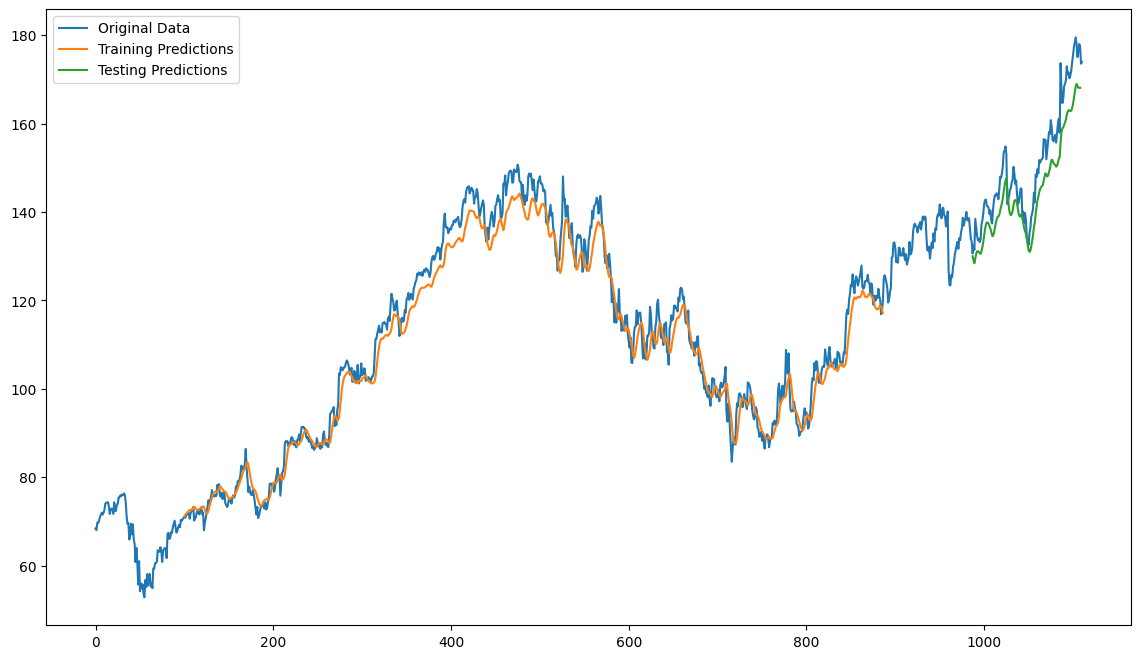

In [13]:
# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(time_step, len(train_predict) + time_step), train_predict, label='Training Predictions')
plt.plot(np.arange(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Testing Predictions')
plt.legend()
plt.show()

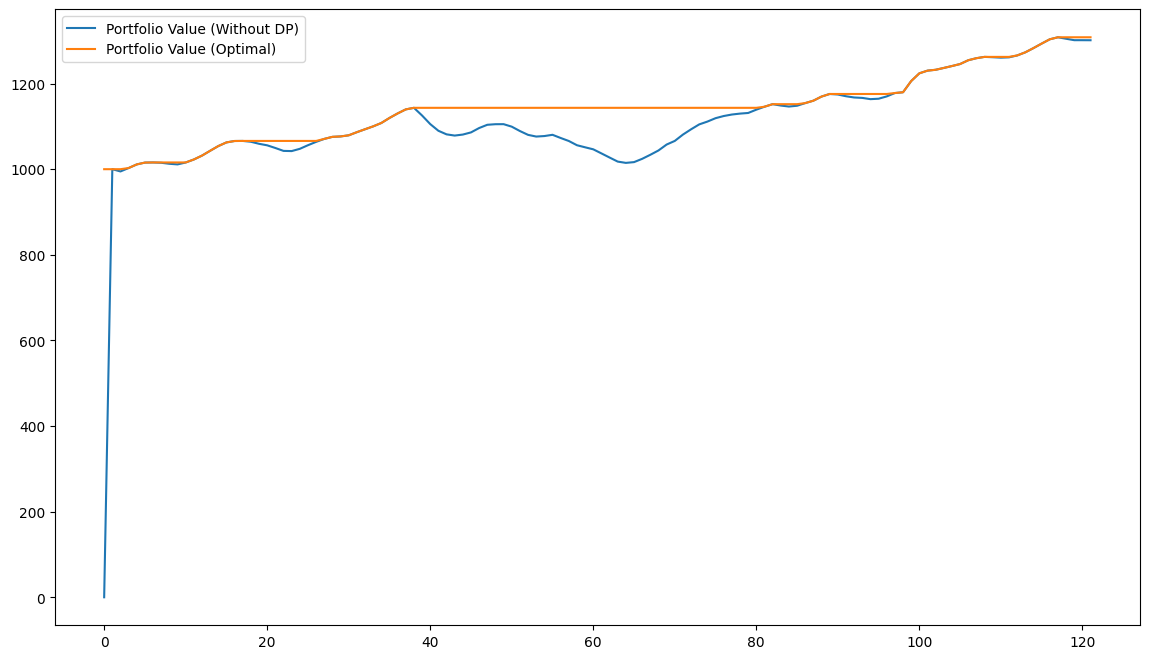

In [14]:
# Plotting the DP table values
plt.figure(figsize=(14, 8))
plt.plot(dp[:, 1] * predictions, label='Portfolio Value (Without DP)')
plt.plot(dp[:, 2], label='Portfolio Value (Optimal)')
plt.legend()
plt.show()